# **Optimizers in Gradient Descent**


Each food item has nutrition information per serving such as its carbohydrates, fat, fibers, vitamins, etc. We know that for unhealthy food items such as fried chicken, we should choose less frequently in our daily diet and for healthy food items such as salad without sauce, we should chooose them more often in our diet. Now given the complexity of the problem, you plan to use Neural Networks to classify those food items.


However, the first neural network you trained had pretty bad performance and essentially underfits the dataset. As a data scientist, you know the performance may be caused by many factors such as bad data quality, architecture of your neural network, non-optimized hyperparameter tuning, etc. So you tried them all and the model result still looks pretty bad.


Then how to improve its performance, in this lab, you will see different optimizers could also play a big role in neural network training process.


## Objectives


* Explain several popular optimizers
* Evaluate their performance in a real-world classification scenario
* (Optional)Implement adam optimizer from scrach


## Prepare and setup the lab environment


In [1]:
%%capture
!pip install --upgrade tensorflow

In [2]:
import pandas as pd
import numpy as np
import time
import sys

import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import keras
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


### Load and explore the dataset


In [3]:
food_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/food_items.csv")

In [4]:
food_df.shape

(13260, 18)

As we can see, it has 13260 data instances and 18 columns (features + label):


In [5]:
food_df.dtypes

,0
Calories,float64
Total Fat,int64
Saturated Fat,float64
Monounsaturated Fat,float64
Polyunsaturated Fat,float64
Trans Fat,float64
Cholesterol,int64
Sodium,float64
Total Carbohydrate,float64
Dietary Fiber,float64


<Axes: xlabel='class'>

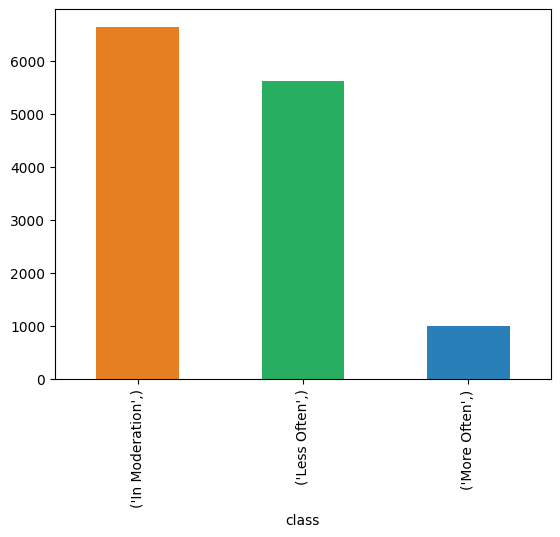

In [6]:
# # Get the row entries with the last col 'class'
food_df.iloc[:, -1:].value_counts(normalize=True)
food_df.iloc[:, -1:].value_counts().plot.bar(color=['#e67e22', '#27ae60', '#2980b9'])

The target variable indicates how often we should include this food item in our diet, and it has three classes `In Moderation`, `Less Often`, `More Often`. It indicates that this is a multi-class classification task and the class distribution is a little bit imbalanced.


## Data processing


Then, let's quickly process the dataset:


First split the features `X` (the input) and labels `y` (the output)


In [7]:
X_raw = food_df.iloc[:, :-1]
y_raw = food_df.iloc[:, -1:]

Then normalize the `X`:


In [8]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Scaling the raw input features
X = scaler.fit_transform(X_raw)

and encode the target variable:


In [9]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

Finally we can split the dataset into training and testing datasets, and we're ready to train a neural network.


In [10]:
rs = 123 # set random state

In [11]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (10608, 17), y_train: (10608,)
Testing dataset shape, X_test: (2652, 17), y_test: (2652,)


## Train a Neural Network with SGD (Stochastic Gradient Descent)


As the initial model, we plan to train a basic multilayer perceptron neural network with the following settings:
- Two hidden layers with shapes `(17, 32)` and `(32, 8)`. Note the number `17` represents the dimension of the feature vector X. You may try different hidden layers setting as well.
- Set the solver/optimizer to be SGD
- Disable momentum
- Enable early stopping


In [12]:
base_ann = MLPClassifier(random_state=rs,  hidden_layer_sizes=(32, 8),
                    solver='sgd', momentum=0,
                    early_stopping=True,
                    max_iter=100)

As you may recall, the formula for SGD is using the gradient calculated from instance `i` only:


$$W_t := W_{t-1} - \alpha \nabla_iJ$$


Then we may use the following helper function to quickly train the neural network and report its training and test score.


In [13]:
def fit_and_score(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start
    n_iter = model.n_iter_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    loss_curve = model.loss_curve_
    return round(fit_time, 2), n_iter, train_score, test_score

In [14]:
fit_time, n_iter, train_score, test_score = fit_and_score(base_ann, X_train, X_test, y_train, y_test)

In [15]:
print(f"Training converged after {n_iter} iterations with train score (accuracy) {round(train_score, 2)} \
and test score (accuracy) {round(test_score, 2)}.")

Training converged after 12 iterations with train score (accuracy) 0.42 and test score (accuracy) 0.42.


As we can see from above cell output, a classification task with accuracy around `40%` is definitly unacceptable. But how is it even possible as we are using a Neural Network to do the task!


Such bad train and test score is normally considered as underfitting which actually happends very often in training neural networks which is normally more complex than shallow models. The reasons could be too simple network architecture, insufficient training data or iterations, trapped in local minima, etc.


For our case, it could be the bad quality or low predictability of our dataset. To verify that, let's try to build a simple logistic regression to see if it can perform the task well.


In [16]:
# Define a logistic regression model with above arguments
lr_model = LogisticRegression(random_state=rs, max_iter = 200)
lr_model.fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)
print(f"The test score for the logistic regression is {round(lr_score, 2)}")

The test score for the logistic regression is 0.77


Now we can see a logistic linear regression can get around 0.75 accuracy which is much better than the neural network. We can see our dataset is pretty predictable. We must have done something improperly in the neural network training.


One common reason is that the SGD was trapped in one of the local minima. Let's illusrate this idea in the following simple example:


First we define a helper function to draw some cost functions.


In [17]:
def draw_cost(X, Y, Z, title):
    fig = plt.figure()
    fig.set_size_inches(8, 6, forward=True)
    fig.set_dpi(100)
    ax = plt.axes(projection='3d')
    ax.view_init(30, 35)
    ax.contour3D(X, Y, Z, 100, cmap=plt.cm.coolwarm)
    ax.set_title(title)

Ideally, a cost function only has one global minima and SGD can find it.


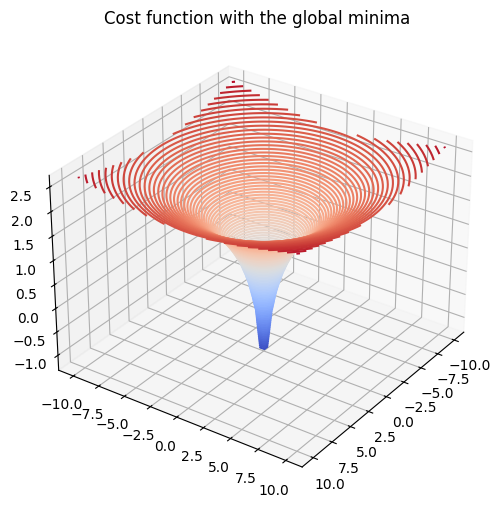

In [18]:
def one_mini_function():
    w1 = np.linspace(-10, 10, 50)
    w2 = np.linspace(-10, 10, 50)
    X, Y = np.meshgrid(w1, w2)
    Z = np.log(np.sqrt(X ** 2 + Y ** 2))
    return X, Y, Z

X, Y, Z = one_mini_function()
draw_cost(X, Y, Z, "Cost function with the global minima")

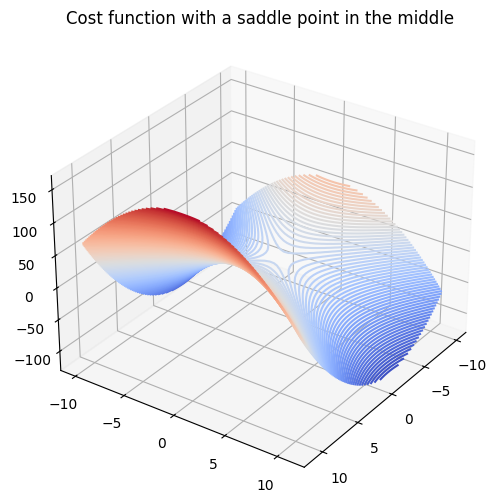

In [19]:
def multi_mini_function():
    w1 = np.linspace(-10, 11, 50)
    w2 = np.linspace(-10, 11, 50)
    X, Y = np.meshgrid(w1, w2)
    Z = X ** 2  - Y ** 2 + 4*X
    return X, Y, Z

X1, Y1, Z1 = multi_mini_function()
draw_cost(X1, Y1, Z1, "Cost function with a saddle point in the middle")

However, if the cost function has multiple minima or even saddle points (where gradients are very small or zeros so the weights won't be updated), the SGD may be stuck at the local minima. For example, the following cost function has a saddle point at `(0, 0)` in the middle which could stop the gradients from further going down, as shown in the following picture:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/saddle.png)


As a result, the total loss won't be reduced and the model would perform badly in the classification task. To tackle this local minima challenge, we could either try to add some noises in SGD or randomly switch the starting point. Furthermore, we may also utilize momentum to make gradient jump out of local minima or saddle points.


## Retrain the Neural Network with momentum


With the regular SGD, the weights are generally moving slowly towards to a optimum (can be a local one like the previous example). Now, with momentum, you're going to smooth out this process. You can do this by taking somewhat of a running average of each of the steps and then smoothing out that variation of each of the individual steps for regular gradient descent.


$$v_t := \eta v_{t-1} + \alpha \nabla J$$


$$W_t := W_{t-1}  - v_t$$


We can see that rather than just simply updating our weights with that gradient, we also look back to prior values $v_{t-1}$ to smooth out these steps. So this is at the step $t$ that we have, which will incorporate some amount of $v_{t-1}$ at step $t-1$.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/momentum.png)


As a summary, adding momentum in weights update may bring the following benefits:
1. Smooth the weight updating process by incorporating previous direction
2. Tend to generate larger and consistent steps which may tackle the saddle points problem


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/jumpout.png)


Let's retrain our neural network with momentum. With `MLPClassifier` class, you just need to give a positive momentum value such as 0.9.


In [20]:
momentum_ann = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8),
                    solver='sgd', momentum=0.9,
                    early_stopping=True,
                    max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(momentum_ann, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with test score (accuracy) {round(test_score, 2)}")

Training converged after 93 iterations with test score (accuracy) 0.73
